In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
# CMIP6 data downloaded from https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/

files = glob.glob("../NorESM2-LM/tasmax_day*")
files.sort()
tasmax_NorESM = xr.open_mfdataset(files)

files = glob.glob("../NorESM2-LM/tasmin_day*")
files.sort()
tasmin_NorESM = xr.open_mfdataset(files)

In [8]:
tmax = tasmax_NorESM.tasmax.sel(lat=slice(57.6, 72.8), 
                        lon=slice(1.4, 34.7), 
                        time=slice('2015-01-01', '2055-01-01'))

tmin = tasmin_NorESM.tasmin.sel(lat=slice(57.6, 72.8), 
                        lon=slice(1.4, 34.7), 
                        time=slice('2015-01-01', '2055-01-01'))
tmin

<xarray.DataArray 'tasmin' (time: 14601, lat: 8, lon: 13)> Size: 6MB
dask.array<getitem, shape=(14601, 8, 13), dtype=float32, chunksize=(1, 8, 13), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 117kB 2015-01-01 12:00:00 ... 2055-01-01 12:00:00
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMN
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-12-06T14:55:16Z altered by CMOR: Treated scalar dime...

## Defintions of climate indices

Defintions from:

Defrance, D. (2019). Dataset of global extreme climatic indices due to an acceleration of ice sheet melting during the 21st century. Data in brief, 27, 104585.

In [28]:
def TNmin(da):
    # Calculate annual minimum temperature
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_minimum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TNmin = min(da_i.values)

                annual_minimum_temperatures[lat, lon, year] = TNmin
    
    return annual_minimum_temperatures



def TXmax(da):
    # Calculate annual maximum temperature
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_maximum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TXmax = max(da_i.values)

                annual_maximum_temperatures[lat, lon, year] = TXmax
    
    return annual_maximum_temperatures

def FD(da):
    # Calculate number of frost days
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_frost_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                print(da_i.values)
                FD = np.sum(da_i.values < 273.15)
                print(FD)
                n_frost_days[lat, lon, year] = FD
    
    return n_frost_days

def ID(da):
    # Calculate number of icing days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_icing_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                ID = np.sum(da_i.values < 273.15)
                n_icing_days[lat, lon, year] = ID
    
    return n_icing_days

def TR(da):
    # Calculate number of tropical nights
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_tropical_nights = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TR = np.sum(da_i.values < 293.15)
                n_tropical_nights[lat, lon, year] = TR
    
    return n_tropical_nights

def SU(da):
    # Calculate number of summer days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_summer_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                SU = np.sum(da_i.values > 298.15)
                n_summer_days[lat, lon, year] = SU
    
    return n_summer_days

def WSDI(da, TXin90):
    # Calculate well spell duration index
    # Input: daily maximum temperature and 90th percentile historical maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    warm_spell_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                non_warm_days = da_i.values < TXin90
                non_warm_days_idx = np.where(non_warm_days)[0]
                WSDI = np.sum(np.diff(non_warm_days_idx) >= time_threshold)

                warm_spell_duration_index[lat, lon, year] = WSDI
    
    return warm_spell_duration_index

def CWDI(da, TNin10):
    # Calculate cold wave duration index
    # Input: daily minimum temperature and 10th percentile historical minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    cold_wave_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                non_cold_days = da_i.values > TNin10
                non_cold_days_idx = np.where(non_cold_days)[0]
                CWDI = np.sum(np.diff(non_cold_days_idx) >= time_threshold)
                print(CWDI)
                cold_wave_duration_index[lat, lon, year] = CWDI
    
    return cold_wave_duration_index


## Calculations of indices for different models, areas and time periods

In [ ]:
# Define dataset specifics

model_name = 'NorESM2-LM'
start_time = '2015-01-01'; end_time = '2055-01-01'
southern_lat = '57.6'; northern_lat = '72.8'
western_lon '3'; eastern_lon = '1.4'; 

files = glob.glob("../"+model_name+"/tasmax_day*")
files.sort()
tasmax = xr.open_mfdataset(files)

files = glob.glob("../"+model_name+"/tasmin_day*")
files.sort()
tasmin = xr.open_mfdataset(files)

tmax = tasmax.tasmax.sel(lat=slice(57.6, 72.8), 
                        lon=slice(1.4, 34.7), 
                        time=slice('2015-01-01', '2055-01-01'))

tmin = tasmin.tasmin.sel(lat=slice(57.6, 72.8), 
                        lon=slice(1.4, 34.7), 
                        time=slice('2015-01-01', '2055-01-01'))

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        annual_minimum_temperature=(["lat", "lon", "time"], TNmin)
    ),
    coords=dict(
        lat=tmin.lat.values,
        lon=tmin.lon.values,
        time=np.arange(2015,2055,1),
    ),
    attrs=dict(description="Annual minimum temperature",
                units="Kelvin"),
)

print(ds)
ds.to_netcdf("../TNmin_NorESM2.nc")

<xarray.Dataset> Size: 34kB
Dimensions:                     (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat                         (lat) float64 64B 57.79 59.68 ... 69.16 71.05
  * lon                         (lon) float64 104B 2.5 5.0 7.5 ... 30.0 32.5
  * time                        (time) int64 320B 0 1 2 3 4 5 ... 35 36 37 38 39
Data variables:
    annual_minimum_temperature  (lat, lon, time) float64 33kB 273.4 ... 258.0
Attributes:
    description:  Annual minimum temperature
    units:        days


41


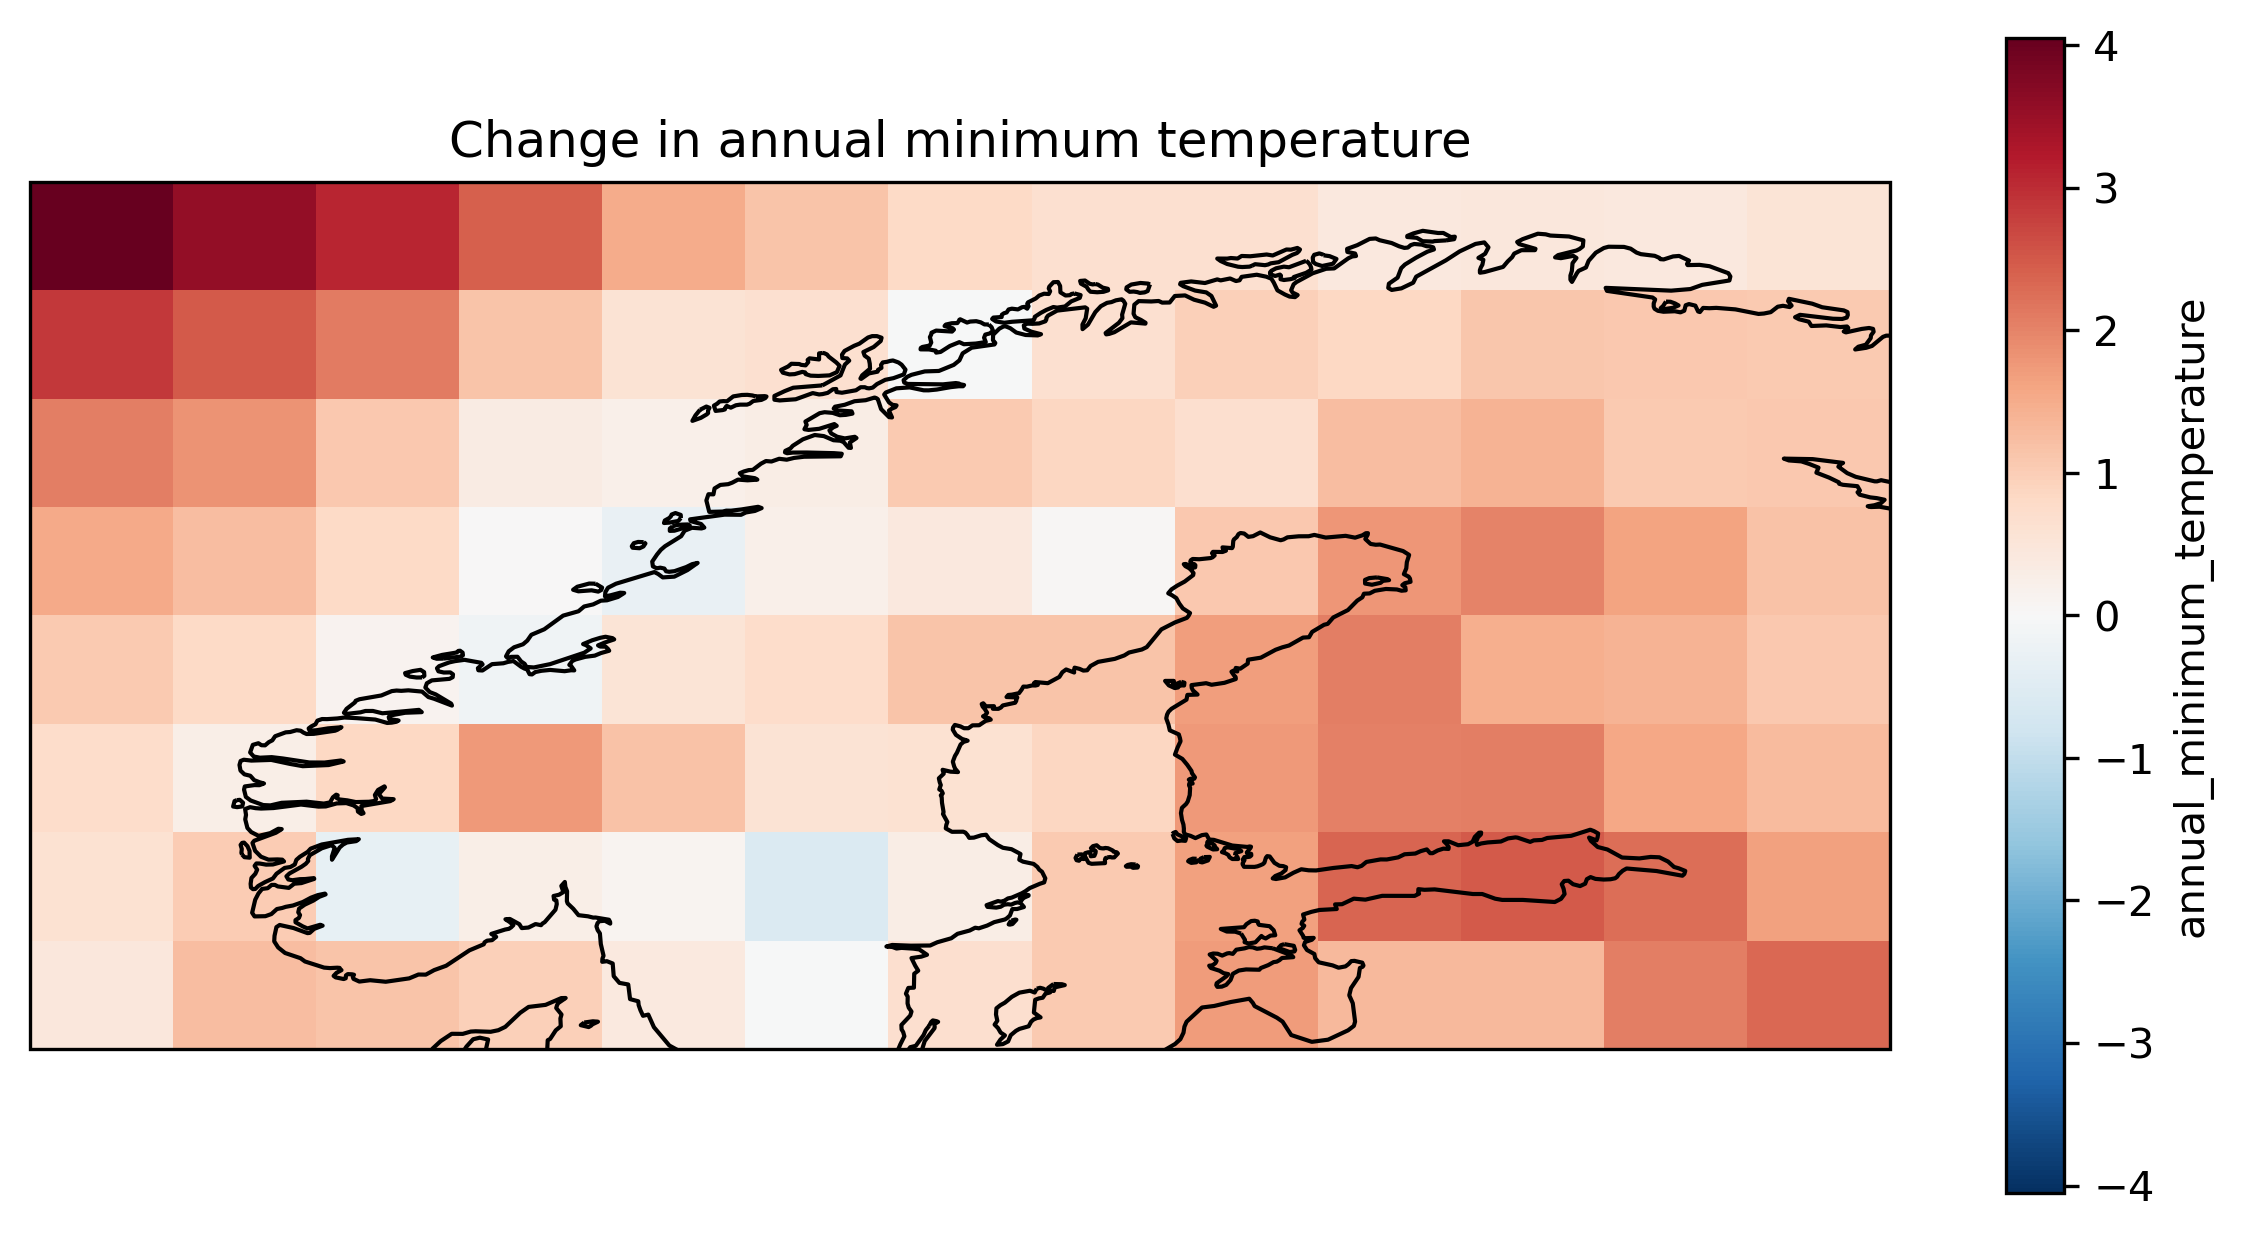

In [7]:
tmin_Norway = xr.open_dataset("../TNmin_NorESM2.nc")
data = tmin_Norway.annual_minimum_temperature
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in annual minimum temperature")

print(len(np.arange(2015,2056,1)))